## Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to C:\Users\Valent
[nltk_data]     Tanda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Valent
[nltk_data]     Tanda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [2]:
data = pd.read_csv('scrapped_data.csv')
data

,userName,content,score,thumbsUpCount,at
0,Pengguna Google,Sumpaahh gue nggak bisa transfer file dari HP ...,5,35,2025-04-03 21:16:55
1,Pengguna Google,"Maaf bgt kesannya jadi gimana,tapi udah terbia...",4,0,2025-04-04 22:45:53
2,Pengguna Google,aplikasi AInya sudah bagus dan cerdas serta bi...,3,15,2025-04-03 03:54:25
3,Pengguna Google,Dulu sebelum update gratis chat nya bisa sampe...,1,8,2025-04-03 16:52:06
4,Pengguna Google,chat gpt udah sangat bagus bgt awalnya dia san...,4,4,2025-04-03 01:24:30
...,...,...,...,...,...
50094,Depan Ya,❤️,5,0,2024-12-20 16:37:11
50095,Yerry Suwarna,Mantap....,5,0,2024-12-22 20:22:10
50096,Fajri Ramadhan,💩,1,0,2025-04-02 16:31:54
50097,24. Nayla Qoni'atun Sholehah,👎,1,0,2024-06-07 18:42:55


## EDA

In [3]:
print("Informasi data:\n", data.info())
print("\nStatistik data:\n", data.describe())
print("\nData hilang:\n", data.isnull().sum())
print("\nData duplikat: ", data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50099 entries, 0 to 50098
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   userName       50099 non-null  object
 1   content        50098 non-null  object
 2   score          50099 non-null  int64 
 3   thumbsUpCount  50099 non-null  int64 
 4   at             50099 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.9+ MB
Informasi data:
 None

Statistik data:
               score  thumbsUpCount
count  50099.000000   50099.000000
mean       4.656121       0.672848
std        0.943064      14.388111
min        1.000000       0.000000
25%        5.000000       0.000000
50%        5.000000       0.000000
75%        5.000000       0.000000
max        5.000000     899.000000

Data hilang:
 userName         0
content          1
score            0
thumbsUpCount    0
at               0
dtype: int64

Data duplikat:  0


In [4]:
# Menghapus data yang hilang
data = data.dropna()
# Menghapus data duplikat
data = data.drop_duplicates()
print("\nData duplikat: ", data.duplicated().sum())
print("\nData hilang:\n", data.isnull().sum())


Data duplikat:  0

Data hilang:
 userName         0
content          0
score            0
thumbsUpCount    0
at               0
dtype: int64


## Data Preprocessing

In [5]:
label = []

for index, row in data.iterrows():
  if row['score'] == 1 or row['score'] == 2:
    label.append("Negatif")
  elif row['score'] == 3:
    label.append("Netral")
  elif row['score'] == 4 or row['score'] == 5:
    label.append("Positif")
data['label'] = label

print(f"Total Sentimen Positif: {len(data[data['label'] == 'Positif'])}")
print(f"Total Sentimen Netral: {len(data[data['label'] == 'Netral'])}")
print(f"Total Sentimen Negatif: {len(data[data['label'] == 'Negatif'])}")

Total Sentimen Positif: 45948
Total Sentimen Netral: 1281
Total Sentimen Negatif: 2869


In [6]:
def clean_text(content):
  content = re.sub(r'@[A-Za-z0-9]+', '', content) # Menghapus mention
  content = re.sub(r'#[A-Za-z0-9]+', '', content) # Menghapus hashtag
  content = re.sub(r'RT[\s]+', '', content) # Menghapus RT
  content = re.sub(r'https?:\/\/\S+', '', content) # Menghapus URL
  content = re.sub(r'[^\w\s]', '', content) # Menghapus karakter khusus
  content = re.sub(r'\d+', '', content) # Menghapus angka
  content = re.sub(r'\s+', ' ', content) # Menghapus spasi ganda
  content = re.sub(r'[^\w\s]', '', content) # menghapus karakter selain huruf dan angka
  content = content.strip() # Menghapus spasi di awal dan akhir teks
  content = content.replace('\n', ' ') # Mengganti baris baru dengan spasi
  return content

def clear_emoji(content):
  return content.encode('ascii', 'ignore').decode('ascii')

def case_folding(content):
  if isinstance(content, str):
    content = content.lower()
  return content

data['cleaned'] = data['content'].apply(clean_text)
data['no_emoji'] = data['cleaned'].apply(clear_emoji)
data['case_folding'] = data['no_emoji'].apply(case_folding)

In [7]:
def tokenize_text(text):
  tokens = word_tokenize(text)
  return tokens
data['tokenized_text'] = data['case_folding'].apply(tokenize_text)

In [8]:
daftar_stopword = stopwords.words('indonesian', 'english')

additional_stopwords = ['yg', 'dg', 'rt', 'dgn', 'ny', 'b'
                        'd', 'klo', 'kalo', 'amp', 'biar',
                        'bikin', 'bilang', 'gak', 'ga', 'kan',
                        'g', 'y', 'sih', 'nya', 'aku', 'dan', 'dia',
                        'mereka', 'dll', 'dsb', 'dst', 'hmm', 'hm', 'bbrp',
                        'lo', 'elo', 'lu', 'deh', 'wkwk', 'hehe', 'betul',
                        'apk', 'aja', 'cuma', 'tdk', 'mulu', 'mlm', 'ngga', 'engga',
                        'tp', 'gk', 'ni', 'nih', 'knp', 'udh']

daftar_stopword.extend(additional_stopwords)

def remove_stopwords(words):
  return [word for word in words if word not in daftar_stopword]
data['stopwords'] = data['tokenized_text'].apply(remove_stopwords)

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
  return stemmer.stem(term)

term_dict = {}

for document in data['stopwords']:
  for term in document:
    if term not in term_dict:
      term_dict[term] = ' '

for term in term_dict:
  term_dict[term] = stemmed_wrapper(term)
  print(term, ":", term_dict[term])

def get_stemmed_term(document):
  return [term_dict[term] for term in document]

data['stemmed_text'] = data['stopwords'].apply(get_stemmed_term)

sumpaahh : sumpaahh
gue : gue
nggak : nggak
transfer : transfer
file : file
hp : hp
samsung : samsung
pc : pc
via : via
usb : usb
udah : udah
coba : coba
aktifin : aktifin
debugging : debugging
ikutin : ikutin
temuin : temuin
google : google
youtube : youtube
tetep : tetep
berhasil : hasil
ngobrol : ngobrol
chatgpt : chatgpt
disarankan : saran
install : install
ulang : ulang
driver : driver
mtp : mtp
manual : manual
ngeinstall : ngeinstall
wpdmtpinf : wpdmtpinf
folder : folder
windows : windows
langsung : langsung
kelar : kelar
terdeteksi : deteksi
maaf : maaf
bgt : bgt
kesannya : kesan
gimanatapi : gimanatapi
terbiasa : biasa
mode : mode
gratis : gratis
tibatiba : tibatiba
photo : photo
or : or
take : take
gambar : gambar
berbayarmana : berbayarmana
harganya : harga
mahal : mahal
pelajarjuga : pelajarjuga
fitur : fitur
ngeselin : ngeselin
suka : suka
ngulang : ngulang
gitu : gitu
semoga : moga
masukannya : masuk
diterima : terima
ya : ya
bantu : bantu
pelajar : ajar
sayangnya : sayang

In [10]:
data.head(1000)

,userName,content,score,thumbsUpCount,at,label,cleaned,no_emoji,case_folding,tokenized_text,stopwords,stemmed_text
0,Pengguna Google,Sumpaahh gue nggak bisa transfer file dari HP ...,5,35,2025-04-03 21:16:55,Positif,Sumpaahh gue nggak bisa transfer file dari HP ...,Sumpaahh gue nggak bisa transfer file dari HP ...,sumpaahh gue nggak bisa transfer file dari hp ...,"[sumpaahh, gue, nggak, bisa, transfer, file, d...","[sumpaahh, gue, nggak, transfer, file, hp, sam...","[sumpaahh, gue, nggak, transfer, file, hp, sam..."
1,Pengguna Google,"Maaf bgt kesannya jadi gimana,tapi udah terbia...",4,0,2025-04-04 22:45:53,Positif,Maaf bgt kesannya jadi gimanatapi udah terbias...,Maaf bgt kesannya jadi gimanatapi udah terbias...,maaf bgt kesannya jadi gimanatapi udah terbias...,"[maaf, bgt, kesannya, jadi, gimanatapi, udah, ...","[maaf, bgt, kesannya, gimanatapi, udah, terbia...","[maaf, bgt, kesan, gimanatapi, udah, biasa, mo..."
2,Pengguna Google,aplikasi AInya sudah bagus dan cerdas serta bi...,3,15,2025-04-03 03:54:25,Netral,aplikasi AInya sudah bagus dan cerdas serta bi...,aplikasi AInya sudah bagus dan cerdas serta bi...,aplikasi ainya sudah bagus dan cerdas serta bi...,"[aplikasi, ainya, sudah, bagus, dan, cerdas, s...","[aplikasi, ainya, bagus, cerdas, skenario, ber...","[aplikasi, ainya, bagus, cerdas, skenario, mas..."
3,Pengguna Google,Dulu sebelum update gratis chat nya bisa sampe...,1,8,2025-04-03 16:52:06,Negatif,Dulu sebelum update gratis chat nya bisa sampe...,Dulu sebelum update gratis chat nya bisa sampe...,dulu sebelum update gratis chat nya bisa sampe...,"[dulu, sebelum, update, gratis, chat, nya, bis...","[update, gratis, chat, sampe, jam, an, menit, ...","[update, gratis, chat, sampe, jam, an, menit, ..."
4,Pengguna Google,chat gpt udah sangat bagus bgt awalnya dia san...,4,4,2025-04-03 01:24:30,Positif,chat gpt udah sangat bagus bgt awalnya dia san...,chat gpt udah sangat bagus bgt awalnya dia san...,chat gpt udah sangat bagus bgt awalnya dia san...,"[chat, gpt, udah, sangat, bagus, bgt, awalnya,...","[chat, gpt, udah, bagus, bgt, membantu, apapun...","[chat, gpt, udah, bagus, bgt, bantu, apa, nyam..."
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Pengguna Google,"aplikasinya membantu bangettttt, aku sering ba...",5,0,2025-02-20 09:26:18,Positif,aplikasinya membantu bangettttt aku sering ban...,aplikasinya membantu bangettttt aku sering ban...,aplikasinya membantu bangettttt aku sering ban...,"[aplikasinya, membantu, bangettttt, aku, serin...","[aplikasinya, membantu, bangettttt, banget, aj...","[aplikasi, bantu, bangettttt, banget, ajarin, ..."
996,Pengguna Google,Aplikasi ini layak dapat bintang 5 karena: ✔️ ...,5,0,2025-03-04 15:14:50,Positif,Aplikasi ini layak dapat bintang karena Bisa m...,Aplikasi ini layak dapat bintang karena Bisa m...,aplikasi ini layak dapat bintang karena bisa m...,"[aplikasi, ini, layak, dapat, bintang, karena,...","[aplikasi, layak, bintang, relevan, sesuai, ar...","[aplikasi, layak, bintang, relevan, sesuai, ar..."
997,Pengguna Google,Aplikasi ini sangat membantu saya banget dalam...,5,0,2025-01-22 00:10:16,Positif,Aplikasi ini sangat membantu saya banget dalam...,Aplikasi ini sangat membantu saya banget dalam...,aplikasi ini sangat membantu saya banget dalam...,"[aplikasi, ini, sangat, membantu, saya, banget...","[aplikasi, membantu, banget, tugas, sekolah, t...","[aplikasi, bantu, banget, tugas, sekolah, teri..."
998,Pengguna Google,bagus open AI ini adalah ai yang bagus bisa di...,5,0,2025-02-18 17:02:44,Positif,bagus open AI ini adalah ai yang bagus bisa di...,bagus open AI ini adalah ai yang bagus bisa di...,bagus open ai ini adalah ai yang bagus bisa di...,"[bagus, open, ai, ini, adalah, ai, yang, bagus...","[bagus, open, ai, ai, bagus, ajak, gobrol, ama...","[bagus, open, ai, ai, bagus, ajak, gobrol, ama..."


## Skema 1:
- Pelatihan: Support Vector Machines (SVM)
- Ekstraksi Fitur: TF-IDF
- Pembagian (Latih/Uji): 70/30

### Ekstraksi Fitur dengan TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Pemisahan data menjadi set latihan dan pengujian (70/30)
X1 = data['stemmed_text']
Y1 = data['label']

x_train1, x_test1, y_train1, y_test1 = model_selection.train_test_split(X1, Y1, test_size=0.3)

vectorizer1 = TfidfVectorizer()
x_train1 = vectorizer1.fit_transform([' '.join(tokens) for tokens in x_train1])
x_test1 = vectorizer1.transform([' '.join(tokens) for tokens in x_test1])
Encoder = LabelEncoder()
y_train1 = Encoder.fit_transform(y_train1)
y_test1 = Encoder.fit_transform(y_test1)

print("Data Latih: ",x_train1.shape, y_train1.shape)
print("\nData Uji: ", x_test1.shape, y_test1.shape)

Data Latih:  (35068, 11364) (35068,)

Data Uji:  (15030, 11364) (15030,)


### Evaluasi dan Confusion Matrix Metode Support Vector Machines

Akurasi data latih:  0.9585376981863808
Akurasi data uji:  0.9308715901530272

Confusion Matrix data latih:


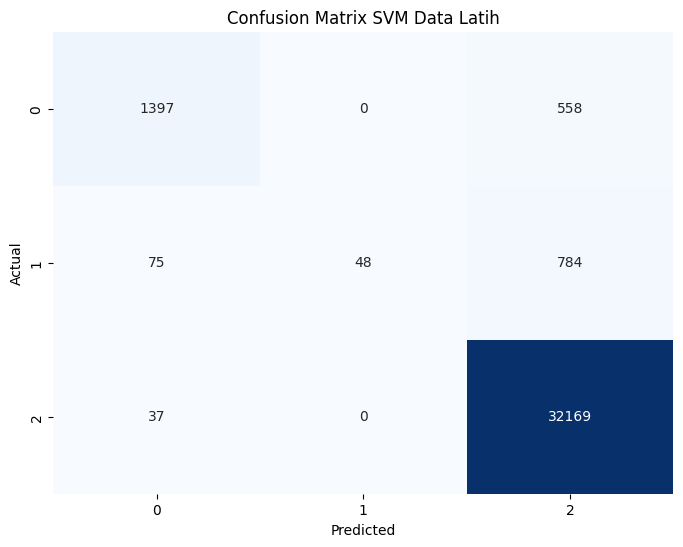


Confusion Matrix data uji:


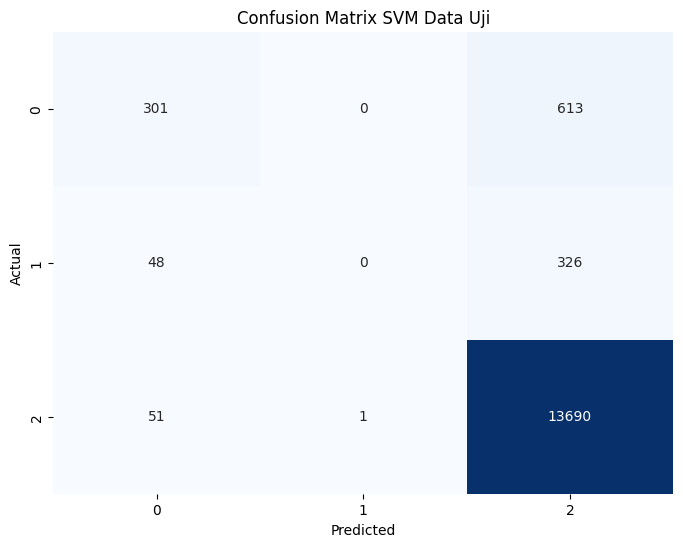

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

svm_model = SVC()
svm_model.fit(x_train1, y_train1)

y_pred_train_svm = svm_model.predict(x_train1.toarray())
y_pred_test_svm = svm_model.predict(x_test1.toarray())

accuracy_train_svm = accuracy_score(y_train1, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test1, y_pred_test_svm)
cm_train = confusion_matrix(y_train1, y_pred_train_svm)
cm_test = confusion_matrix(y_test1, y_pred_test_svm)

print("Akurasi data latih: ", accuracy_train_svm)
print("Akurasi data uji: ", accuracy_test_svm)

# Heatmap confusion matrix untuk data latih
print("\nConfusion Matrix data latih:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix SVM Data Latih')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Heatmap confusion matrix untuk data uji
print("\nConfusion Matrix data uji:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix SVM Data Uji')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Kesimpulan:** Pada skema 1, hasil yang diperoleh memiliki nilai akurasi sebesar 93.08% pada data uji

## Skema 2:
- Pelatihan: Random Forest (RF)
- Ekstraksi Fitur: TF-IDF
- Pembagian (Latih/Uji): 70/30

### Ekstraksi Fitur dengan TF-IDF

In [26]:
# Pemisahan data menjadi set latihan dan pengujian (70/30)
X2 = data['stemmed_text']
Y2 = data['label']

x_train2, x_test2, y_train2, y_test2 = model_selection.train_test_split(X2, Y2, test_size=0.3)

vectorizer2 = TfidfVectorizer()
x_train2 = vectorizer2.fit_transform([' '.join(tokens) for tokens in x_train2])
x_test2 = vectorizer2.transform([' '.join(tokens) for tokens in x_test2])
Encoder = LabelEncoder()
y_train2 = Encoder.fit_transform(y_train2)
y_test2 = Encoder.fit_transform(y_test2)

print("Data Latih: ",x_train2.shape, y_train2.shape)
print("\nData Uji: ", x_test2.shape, y_test2.shape)

Data Latih:  (35068, 11425) (35068,)

Data Uji:  (15030, 11425) (15030,)


### Evaluasi dan Confusion Matrix Metode Random Forest

Akurasi data latih:  0.9846868940344473
Akurasi data uji:  0.930938123752495

Confusion Matrix data latih:


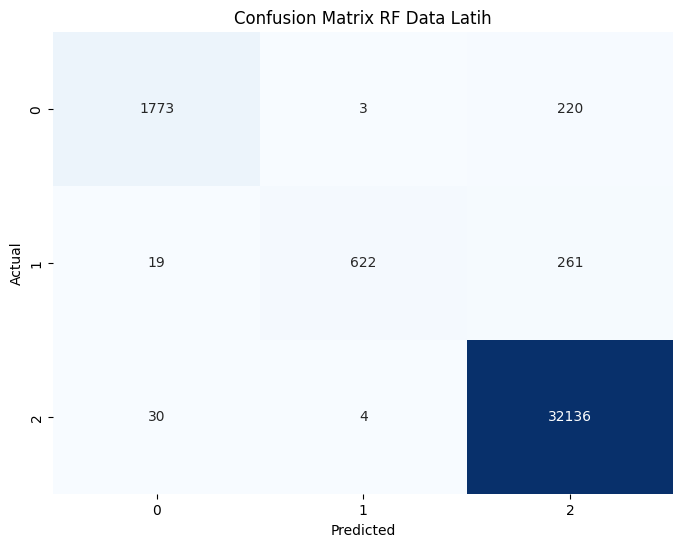


Confusion Matrix data uji:


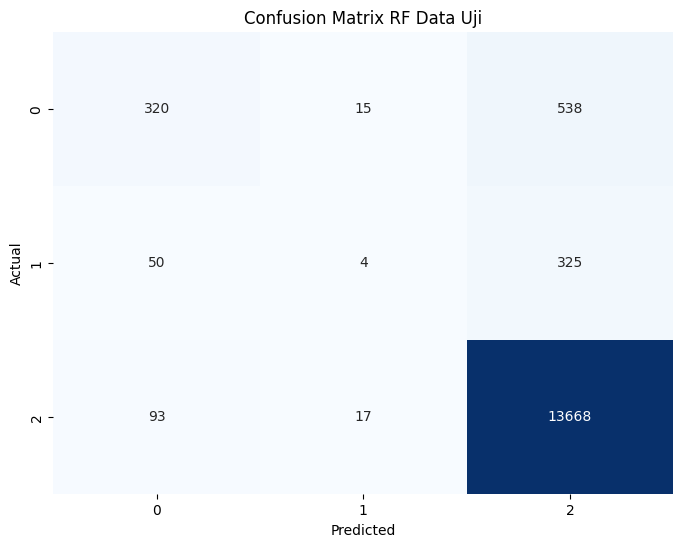

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

rf_model = RandomForestClassifier()
rf_model.fit(x_train2, y_train2)

y_pred_train_rf = rf_model.predict(x_train2.toarray())
y_pred_test_rf = rf_model.predict(x_test2.toarray())

accuracy_train_rf = accuracy_score(y_train2, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test2, y_pred_test_rf)

cm_train = confusion_matrix(y_train2, y_pred_train_rf)
cm_test = confusion_matrix(y_test2, y_pred_test_rf)

print("Akurasi data latih: ", accuracy_train_rf)
print("Akurasi data uji: ", accuracy_test_rf)

# Heatmap confusion matrix untuk data latih
print("\nConfusion Matrix data latih:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix RF Data Latih')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Heatmap confusion matrix untuk data uji
print("\nConfusion Matrix data uji:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix RF Data Uji')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Kesimpulan:** Pada skema 2, hasil yang diperoleh memiliki nilai sebesar 93.09% pada data uji

## Skema 3:
- Pelatihan: Support Vector Machines (SVM)
- Ekstraksi Fitur: Bag of Words (BoW)
- Pembagian (Latih/Uji): 65/35

### Ekstraksi Fitur dengan Bag of Words

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X3 = data['stemmed_text']
Y3 = data['label']

x_train3, x_test3, y_train3, y_test3 = model_selection.train_test_split(X3, Y3, test_size=0.35)

vectorizer3 = CountVectorizer()
x_train3 = vectorizer3.fit_transform([' '.join(tokens) for tokens in x_train3])
x_test3 = vectorizer3.transform([' '.join(tokens) for tokens in x_test3])
Encoder = LabelEncoder()
y_train3 = Encoder.fit_transform(y_train3)
y_test3 = Encoder.fit_transform(y_test3)

print("Data Latih: ",x_train3.shape, y_train3.shape)
print("\nData Uji: ", x_test3.shape, y_test3.shape)

Data Latih:  (32563, 10745) (32563,)

Data Uji:  (17535, 10745) (17535,)


### Evaluasi dan Confusion Matrix Metode SVM

Akurasi data latih:  0.9613364861959893
Akurasi data uji:  0.9278015397775877

Confusion Matrix data latih:


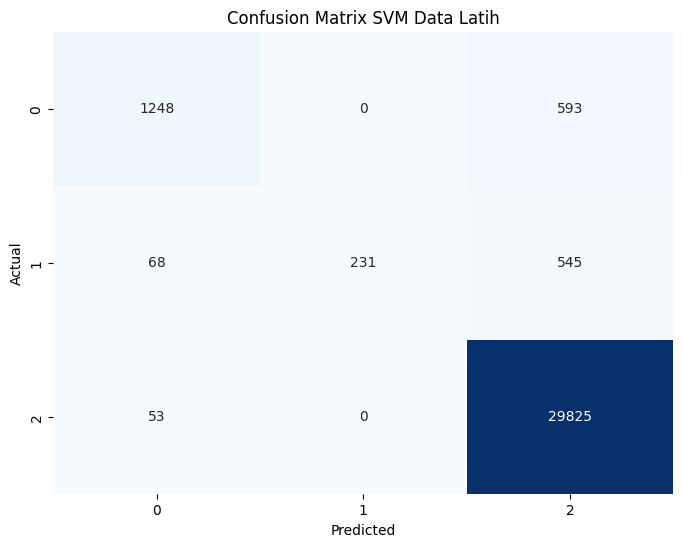


Confusion Matrix data uji:


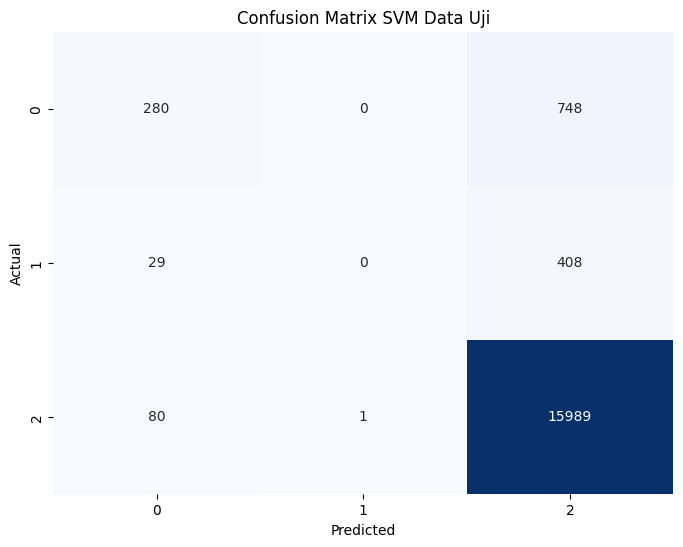

In [29]:
svm_model2 = SVC()
svm_model2.fit(x_train3, y_train3)

y_pred_train_svm1 = svm_model2.predict(x_train3.toarray())
y_pred_test_svm1 = svm_model2.predict(x_test3.toarray())

accuracy_train_svm1 = accuracy_score(y_train3, y_pred_train_svm1)
accuracy_test_svm1 = accuracy_score(y_test3, y_pred_test_svm1)
cm_train = confusion_matrix(y_train3, y_pred_train_svm1)
cm_test = confusion_matrix(y_test3, y_pred_test_svm1)

print("Akurasi data latih: ", accuracy_train_svm1)
print("Akurasi data uji: ", accuracy_test_svm1)

# Heatmap confusion matrix untuk data latih
print("\nConfusion Matrix data latih:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix SVM Data Latih')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Heatmap confusion matrix untuk data uji
print("\nConfusion Matrix data uji:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix SVM Data Uji')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Kesimpulan:** Pada skema 3, hasil yang diperoleh memiliki nilai sebesar 92.78% pada data uji

## Rangkuman Hasil Tiap Skema

In [30]:
# Rangkuman hasil evaluasi akurasi tiap skema
print("Hasil evaluasi akurasi tiap skema:")

hasil = pd.DataFrame({
    'Skema': ['Skema 1', 'Skema 2', 'Skema 3'],
    'Akurasi Data Latih': [accuracy_train_svm, accuracy_train_rf, accuracy_train_svm1],
    'Akurasi Data Uji': [accuracy_test_svm, accuracy_test_rf, accuracy_test_svm1]
})

print(hasil)

Hasil evaluasi akurasi tiap skema:
     Skema  Akurasi Data Latih  Akurasi Data Uji
0  Skema 1            0.958538          0.930872
1  Skema 2            0.984687          0.930938
2  Skema 3            0.961336          0.927802


**Kesimpulan:** Berdasarkan hasil dari nilai akurasi setiap skema yang dilakukan, terlihat bahwa skema 2 memiliki nilai akurasi data uji paling tinggi, yaitu sekitar 93.09%, diikuti dengan skema 1 dengan 93.08%, dan skema 3 dengan 92.78%. Ini dapat disimpulkan bahwa meskipun skema 1 dan skema 2 memiliki model pelatihan yang berbeda (SVM dan RF), namun dengan menggunakan ekstraksi fitur TF-IDF dapat menghasilkan nilai akurasi yang tinggi, dan perbedaan nilai akurasi yang dihasilkan keduanya hanya sebesar 0.01%. Dapat disimpulkan bahwa untuk kasus ini, skema 1 dan skema 2 dapat dianggap sebagai skema yang paling efektif dalam melakukan klasifikasi teks berdasarkan kategori yang telah ditentukan

## Word Cloud untuk Setiap Sentimen

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [19]:
train_0 = data[data['label'] == 'Negatif']
train_1 = data[data['label'] == 'Netral']
train_2 = data[data['label'] == 'Positif']

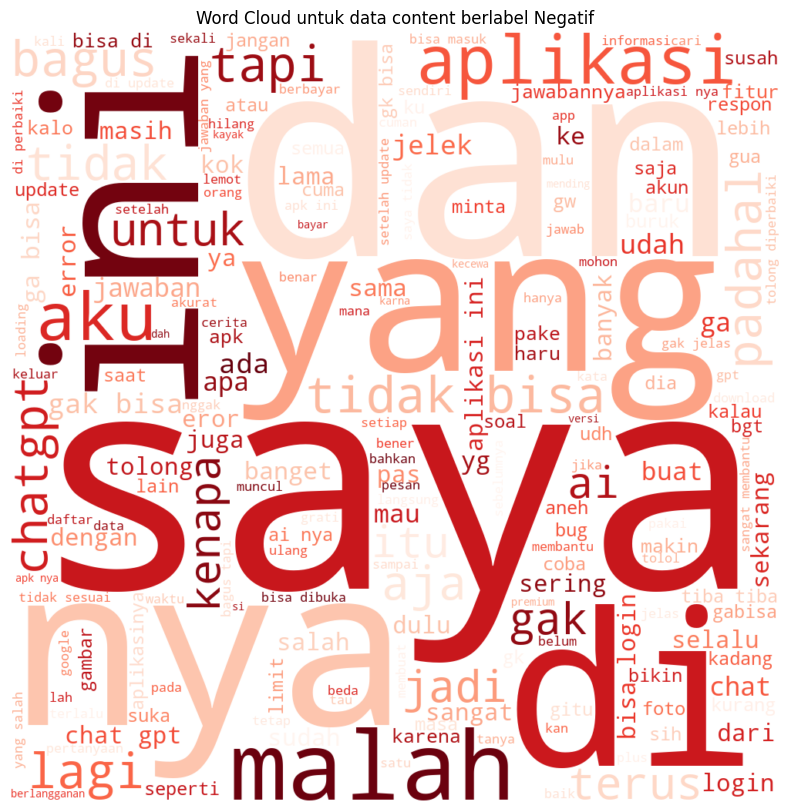

In [20]:
all_text_0 = ' '.join(word for word in train_0 ['content'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title("Word Cloud untuk data content berlabel Negatif")
plt.show()

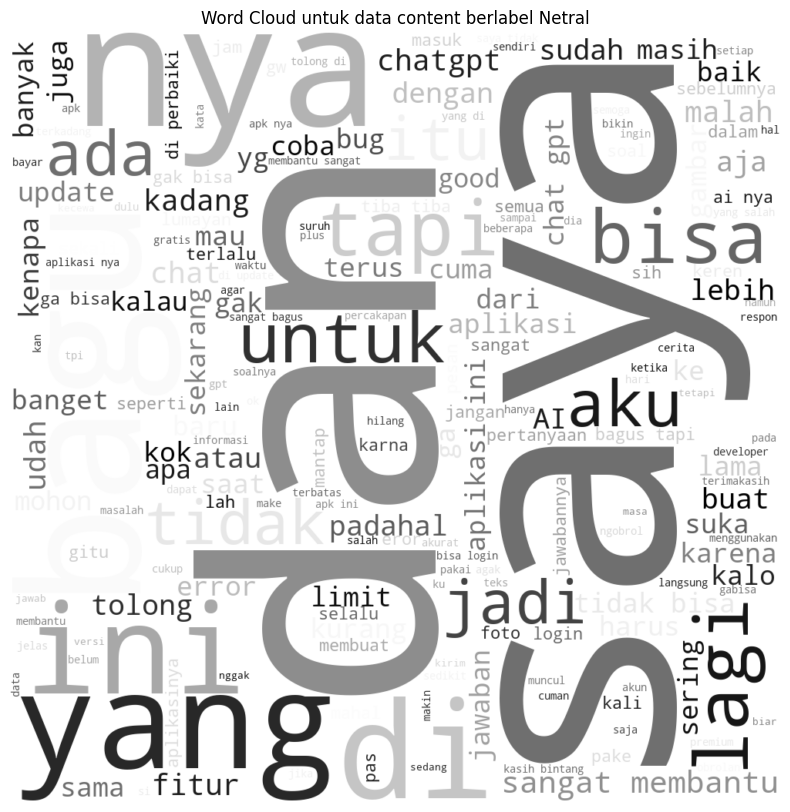

In [21]:
all_text_1 = ' '.join(word for word in train_1 ['content'])
wordcloud = WordCloud(colormap='Grays', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_1)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title("Word Cloud untuk data content berlabel Netral")
plt.show()

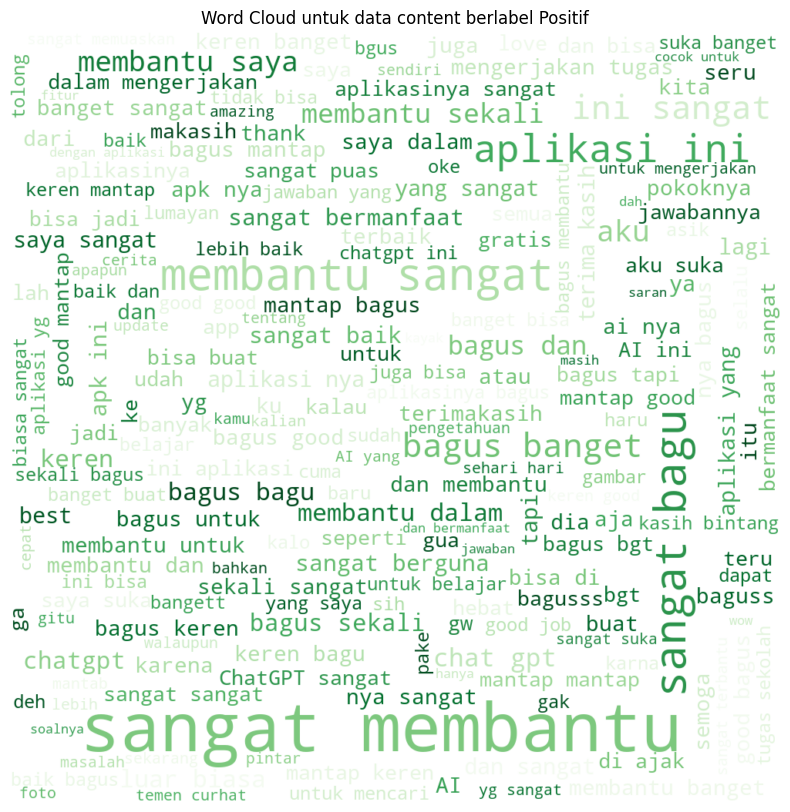

In [22]:
all_text_2 = ' '.join(word for word in train_2 ['content'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_2)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title("Word Cloud untuk data content berlabel Positif")
plt.show()

## Menyimpan Semua Model dan Vectorizer dengan Format .pkl

In [31]:
import joblib

joblib.dump(svm_model, 'model1.pkl')
joblib.dump(rf_model, 'model2.pkl')
joblib.dump(svm_model2, 'model3.pkl')

joblib.dump(vectorizer1, 'vectorizer1.pkl')
joblib.dump(vectorizer2, 'vectorizer2.pkl')
joblib.dump(vectorizer3, 'vectorizer3.pkl')

['vectorizer3.pkl']